## YIELD PREDICTION

#### TO PREDICT:
           *Production 
           *Yield = Production / Area 
Yield tells the efficiency of the farming

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pyplot 
import sklearn

from pandas.api.types import is_numeric_dtype, is_bool_dtype

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold

import joblib

In [2]:
data = pd.read_csv("Yield-predictor/crop_yield.csv")
for col in ['State', 'Crop', 'Season']:
    data[col] = data[col].str.strip()

In [3]:
data["Production"].describe()

count    1.968900e+04
mean     1.643594e+07
std      2.630568e+08
min      0.000000e+00
25%      1.393000e+03
50%      1.380400e+04
75%      1.227180e+05
max      6.326000e+09
Name: Production, dtype: float64

In [4]:
data.count()

Crop               19689
Crop_Year          19689
Season             19689
State              19689
Area               19689
Production         19689
Annual_Rainfall    19689
Fertilizer         19689
Pesticide          19689
Yield              19689
dtype: int64

In [5]:
data.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [6]:
data.info()
data.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19689 entries, 0 to 19688
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Crop             19689 non-null  object 
 1   Crop_Year        19689 non-null  int64  
 2   Season           19689 non-null  object 
 3   State            19689 non-null  object 
 4   Area             19689 non-null  float64
 5   Production       19689 non-null  int64  
 6   Annual_Rainfall  19689 non-null  float64
 7   Fertilizer       19689 non-null  float64
 8   Pesticide        19689 non-null  float64
 9   Yield            19689 non-null  float64
dtypes: float64(5), int64(2), object(3)
memory usage: 1.5+ MB


Crop               0
Crop_Year          0
Season             0
State              0
Area               0
Production         0
Annual_Rainfall    0
Fertilizer         0
Pesticide          0
Yield              0
dtype: int64

#### No null data found in data set

In [7]:
data.describe()

,Crop_Year,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
count,19689.000000,1.968900e+04,1.968900e+04,19689.000000,1.968900e+04,1.968900e+04,19689.000000
mean,2009.127584,1.799266e+05,1.643594e+07,1437.755177,2.410331e+07,4.884835e+04,79.954009
std,6.498099,7.328287e+05,2.630568e+08,816.909589,9.494600e+07,2.132874e+05,878.306193
min,1997.000000,5.000000e-01,0.000000e+00,301.300000,5.417000e+01,9.000000e-02,0.000000
25%,2004.000000,1.390000e+03,1.393000e+03,940.700000,1.880146e+05,3.567000e+02,0.600000
50%,2010.000000,9.317000e+03,1.380400e+04,1247.600000,1.234957e+06,2.421900e+03,1.030000
75%,2015.000000,7.511200e+04,1.227180e+05,1643.700000,1.000385e+07,2.004170e+04,2.388889
max,2020.000000,5.080810e+07,6.326000e+09,6552.700000,4.835407e+09,1.575051e+07,21105.000000


## Converting object to boolean

#### Function to check for null and removing object data type

In [8]:
data.head()

,Crop,Crop_Year,Season,State,Area,Production,Annual_Rainfall,Fertilizer,Pesticide,Yield
0,Arecanut,1997,Whole Year,Assam,73814.0,56708,2051.4,7024878.38,22882.34,0.796087
1,Arhar/Tur,1997,Kharif,Assam,6637.0,4685,2051.4,631643.29,2057.47,0.710435
2,Castor seed,1997,Kharif,Assam,796.0,22,2051.4,75755.32,246.76,0.238333
3,Coconut,1997,Whole Year,Assam,19656.0,126905000,2051.4,1870661.52,6093.36,5238.051739
4,Cotton(lint),1997,Kharif,Assam,1739.0,794,2051.4,165500.63,539.09,0.420909


In [9]:

def compute_imputation_values(df):
    """
    Compute imputation values for each column and store in a dictionary.
    """
    impute_values = {}
    
    for col in df.columns:
        if is_numeric_dtype(df[col]):
            impute_values[col] = df[col].median()
        elif is_bool_dtype(df[col]):
            impute_values[col] = 0
        else:
            # Categorical: fill with 'Unknown' instead of mode
            impute_values[col] = 'Unknown'
    
    return impute_values

def fill_nulls(df, impute_values):
    """
    Fill nulls using precomputed imputation values.
    """
    for col, value in impute_values.items():
        df[col] = df[col].fillna(value)
    return df

In [10]:

# Example usage:
impute_values = compute_imputation_values(data)  # store values
data = fill_nulls(data, impute_values)   

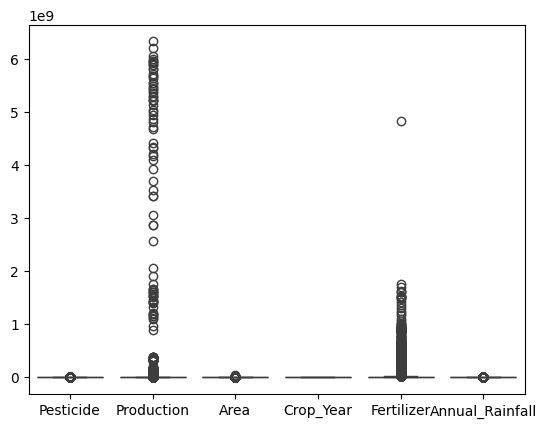

In [11]:

# Example for one column
sns.boxplot(data=data[['Pesticide','Production','Area','Crop_Year','Fertilizer','Pesticide','Annual_Rainfall']])
plt.show()

## Since there are so many outlier..... we are goin to do
> y = log(x+1) // +1 bocoz log(0) would break
#### Then use MinMaxScaler to make it as values between 0 and 1
> MinMaxScaler()

#### After predicting
> x= e^y -1 
>
> Reverse MinMaxScaler (scaler.inverse_transform)

    

In [12]:
categorical_columns = ['State', 'Crop', 'Season']

# Work on the full dataset
df = data.copy()

# Strip spaces in categorical columns BEFORE encoding
df[categorical_columns] = df[categorical_columns].apply(lambda x: x.str.strip())

# One-hot encode categorical columns
df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

# Drop target column
df = df.drop('Yield', axis=1)

# Save the column order for backend
model_columns = df.columns.tolist()


#Need Log Feature for
>'Pesticide','Production','Area','Fertilizer','Pesticide'

In [13]:
# Create a new DataFrame with log-transformed columns
columns_to_log=['Pesticide', 'Area', 'Fertilizer', 'Annual_Rainfall','Production']
log_df = pd.DataFrame({col + '_log': np.log1p(df[col]) for col in columns_to_log})

# Concatenate the new log columns with the original DataFrame
df = pd.concat([df, log_df], axis=1)

print(df.head())

   Crop_Year     Area  Production  Annual_Rainfall  Fertilizer  Pesticide  \
0       1997  73814.0       56708           2051.4  7024878.38   22882.34   
1       1997   6637.0        4685           2051.4   631643.29    2057.47   
2       1997    796.0          22           2051.4    75755.32     246.76   
3       1997  19656.0   126905000           2051.4  1870661.52    6093.36   
4       1997   1739.0         794           2051.4   165500.63     539.09   

   State_Andhra Pradesh  State_Arunachal Pradesh  State_Assam  State_Bihar  \
0                 False                    False         True        False   
1                 False                    False         True        False   
2                 False                    False         True        False   
3                 False                    False         True        False   
4                 False                    False         True        False   

   ...  Season_Kharif  Season_Rabi  Season_Summer  Season_Whole Year

In [14]:
df = df.drop(columns=columns_to_log)

In [15]:
dupes = df.columns[df.columns.duplicated()]
print("Duplicated columns:", dupes)

df = df.loc[:, ~df.columns.duplicated()]

Duplicated columns: Index([], dtype='object')


In [16]:

# --- Features ---
# --- Feature scaling ---
feature_columns = ['Pesticide_log','Fertilizer_log','Area_log', 'Annual_Rainfall_log']
scaler_X = MinMaxScaler()
X_scaled = scaler_X.fit_transform(df[feature_columns])

# Convert to DataFrame with '_scaled' suffix
scaled_features_df = pd.DataFrame(
    X_scaled, 
    columns=[col.replace('_log', '_scaled') for col in feature_columns]
)

# Drop original log columns from features and concatenate scaled ones
df = df.drop(columns=feature_columns)
df = pd.concat([df, scaled_features_df], axis=1)

# --- Target scaling ---
target_column = ['Production_log']
#scaler_y = MinMaxScaler()
y_scaled = df[target_column]#scaler_y.fit_transform(df[target_column])

#df = df.drop(columns=['Production_log'])
print(df.head())

   Crop_Year  State_Andhra Pradesh  State_Arunachal Pradesh  State_Assam  \
0       1997                 False                    False         True   
1       1997                 False                    False         True   
2       1997                 False                    False         True   
3       1997                 False                    False         True   
4       1997                 False                    False         True   

   State_Bihar  State_Chhattisgarh  State_Delhi  State_Goa  State_Gujarat  \
0        False               False        False      False          False   
1        False               False        False      False          False   
2        False               False        False      False          False   
3        False               False        False      False          False   
4        False               False        False      False          False   

   State_Haryana  ...  Season_Kharif  Season_Rabi  Season_Summer  \
0          F

In [17]:
#target = "Production_scaled"
features =df
y = y_scaled    


In [18]:
print(features.columns.tolist())

['Crop_Year', 'State_Andhra Pradesh', 'State_Arunachal Pradesh', 'State_Assam', 'State_Bihar', 'State_Chhattisgarh', 'State_Delhi', 'State_Goa', 'State_Gujarat', 'State_Haryana', 'State_Himachal Pradesh', 'State_Jammu and Kashmir', 'State_Jharkhand', 'State_Karnataka', 'State_Kerala', 'State_Madhya Pradesh', 'State_Maharashtra', 'State_Manipur', 'State_Meghalaya', 'State_Mizoram', 'State_Nagaland', 'State_Odisha', 'State_Puducherry', 'State_Punjab', 'State_Sikkim', 'State_Tamil Nadu', 'State_Telangana', 'State_Tripura', 'State_Uttar Pradesh', 'State_Uttarakhand', 'State_West Bengal', 'Crop_Arecanut', 'Crop_Arhar/Tur', 'Crop_Bajra', 'Crop_Banana', 'Crop_Barley', 'Crop_Black pepper', 'Crop_Cardamom', 'Crop_Cashewnut', 'Crop_Castor seed', 'Crop_Coconut', 'Crop_Coriander', 'Crop_Cotton(lint)', 'Crop_Cowpea(Lobia)', 'Crop_Dry chillies', 'Crop_Garlic', 'Crop_Ginger', 'Crop_Gram', 'Crop_Groundnut', 'Crop_Guar seed', 'Crop_Horse-gram', 'Crop_Jowar', 'Crop_Jute', 'Crop_Khesari', 'Crop_Linseed',

In [19]:
# features.columns = features.columns.str.strip()
# X_train, X_test, y_train, y_test = train_test_split(
#     features, y, test_size=0.2, random_state=42
# )

# # 2️⃣ Split train/test
# X_train, X_test, y_train, y_test = train_test_split(
#     features, y, test_size=0.2, random_state=42
# )

In [20]:
# from sklearn.preprocessing import MinMaxScaler

# # 9️⃣ Scale target (optional)
# y_train_log = np.log1p(y_train.values).reshape(-1, 1)  # if y_train is a NumPy array
# y_test_log  = np.log1p(y_test.values).reshape(-1, 1)

# Scale target
# scaler_y = MinMaxScaler()
# y_train_scaled = scaler_y.fit_transform(y_train_log)
# y_test_scaled  = scaler_y.transform(y_test_log)

# Save target scaler for backend
#joblib.dump(scaler_y, "scaler_y.pkl")

In [21]:
numeric_cols = ['Pesticide', 'Fertilizer', 'Area', 'Annual_Rainfall']

# Make sure they exist
print([col for col in numeric_cols if col not in features.columns])

['Pesticide', 'Fertilizer', 'Area', 'Annual_Rainfall']


In [22]:
# 2️⃣ Split train/test
X_train, X_test, y_train, y_test = train_test_split(
    features.drop('Production_log',axis=1), y, test_size=0.3, random_state=42
)
model_columns = X_train.columns.tolist()

X_train.columns = X_train.columns.str.strip()
X_test.columns = X_test.columns.str.strip()

# 5️⃣ Save artifacts
joblib.dump(scaler_X, "scaler_X.pkl")
joblib.dump(model_columns, "model_columns.pkl")

['model_columns.pkl']

In [23]:
model_columns

['Crop_Year',
 'State_Andhra Pradesh',
 'State_Arunachal Pradesh',
 'State_Assam',
 'State_Bihar',
 'State_Chhattisgarh',
 'State_Delhi',
 'State_Goa',
 'State_Gujarat',
 'State_Haryana',
 'State_Himachal Pradesh',
 'State_Jammu and Kashmir',
 'State_Jharkhand',
 'State_Karnataka',
 'State_Kerala',
 'State_Madhya Pradesh',
 'State_Maharashtra',
 'State_Manipur',
 'State_Meghalaya',
 'State_Mizoram',
 'State_Nagaland',
 'State_Odisha',
 'State_Puducherry',
 'State_Punjab',
 'State_Sikkim',
 'State_Tamil Nadu',
 'State_Telangana',
 'State_Tripura',
 'State_Uttar Pradesh',
 'State_Uttarakhand',
 'State_West Bengal',
 'Crop_Arecanut',
 'Crop_Arhar/Tur',
 'Crop_Bajra',
 'Crop_Banana',
 'Crop_Barley',
 'Crop_Black pepper',
 'Crop_Cardamom',
 'Crop_Cashewnut',
 'Crop_Castor seed',
 'Crop_Coconut',
 'Crop_Coriander',
 'Crop_Cotton(lint)',
 'Crop_Cowpea(Lobia)',
 'Crop_Dry chillies',
 'Crop_Garlic',
 'Crop_Ginger',
 'Crop_Gram',
 'Crop_Groundnut',
 'Crop_Guar seed',
 'Crop_Horse-gram',
 'Crop_J

In [24]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Predict on test set
y_pred = model.predict(X_test)

# Evaluate performance
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae}")
print(f"RMSE : {rmse}")
print(f"R²   : {r2}")

MAE  : 0.44539821956009756
RMSE : 0.7335837691575409
R²   : 0.9542076385952385


In [25]:
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
ohe.fit(data[categorical_columns])

,categories,'auto'
,drop,None
,sparse_output,False
,dtype,<class 'numpy.float64'>
,handle_unknown,'ignore'
,min_frequency,None
,max_categories,None
,feature_name_combiner,'concat'


In [26]:
cat_train = data[categorical_columns]
ohe_array = ohe.transform(cat_train)
ohe_df = pd.DataFrame(
    ohe_array, 
    columns=ohe.get_feature_names_out(categorical_columns), 
    index=cat_train.index  # not df.index!
)
ohe_df.columns = [c.strip() for c in ohe_df.columns]
# Drop old categorical columns and merge new OHE columns
df = df.drop(columns=categorical_columns, errors='ignore')
df = pd.concat([df, ohe_df], axis=1)
# Add missing columns that the model expects (set to 0)
for col in model_columns:
    if col not in df.columns:
        df[col] = 0

# Reorder to match model
df = df[model_columns]

In [27]:
joblib.dump(ohe, "ohe_features.pkl")

['ohe_features.pkl']

In [28]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13782 entries, 13103 to 15795
Data columns (total 96 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Crop_Year                   13782 non-null  int64  
 1   State_Andhra Pradesh        13782 non-null  bool   
 2   State_Arunachal Pradesh     13782 non-null  bool   
 3   State_Assam                 13782 non-null  bool   
 4   State_Bihar                 13782 non-null  bool   
 5   State_Chhattisgarh          13782 non-null  bool   
 6   State_Delhi                 13782 non-null  bool   
 7   State_Goa                   13782 non-null  bool   
 8   State_Gujarat               13782 non-null  bool   
 9   State_Haryana               13782 non-null  bool   
 10  State_Himachal Pradesh      13782 non-null  bool   
 11  State_Jammu and Kashmir     13782 non-null  bool   
 12  State_Jharkhand             13782 non-null  bool   
 13  State_Karnataka             1378

# Scalling to original numbers

In [29]:

# Step 2: Inverse-transform predictions (from scaled to log scale)
#y_pred_log = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

# Step 3: Reverse log1p to get original units

#y_pred_log = scaler_y.inverse_transform(y_pred.reshape(-1, 1))
#y_pred_original = np.expm1(y_pred_log)
# y_test_log = scaler_y.inverse_transform(y_test.reshape(-1, 1))
# y_test_original = np.expm1(y_test_log)

## Score after changing the numbers back

In [30]:
comparison = pd.DataFrame({
    'Actual': y_test.values.ravel(),
    'Predicted': y_pred.ravel()
})
pd.set_option('display.float_format', '{:.2f}'.format)
print(comparison.head(10))

   Actual  Predicted
0    6.92       4.88
1    9.24       9.31
2   10.69      11.16
3   10.21      10.05
4    8.51       8.58
5    4.55       4.43
6    8.85       8.46
7    9.33       9.42
8   14.51      13.95
9    3.97       3.39


In [31]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE  : {mae}")
print(f"RMSE : {rmse}")
print(f"R²   : {r2}")

MAE  : 0.44539821956009756
RMSE : 0.7335837691575409
R²   : 0.9542076385952385


In [32]:
y_test_original = np.expm1(y_test)
y_pred_original = np.expm1(y_pred)
# y_test_original = np.expm1(y_test_original)
# y_pred_original = np.expm1(y_pred_original)

In [33]:
comparison = pd.DataFrame({
    'Actual': y_test_original.values.ravel(),
    'Predicted': y_pred_original.ravel()
})
pd.set_option('display.float_format', '{:.2f}'.format)
print(comparison.head(10))

      Actual  Predicted
0    1010.00     130.49
1   10280.00   11053.12
2   44026.00   70318.51
3   27189.00   23257.43
4    4970.00    5319.35
5      94.00      82.55
6    7005.00    4733.73
7   11324.00   12377.15
8 2001900.00 1142000.88
9      52.00      28.57


In [34]:
comparison['Actual_original'] = np.expm1(comparison['Actual'])
comparison['Predicted_original'] = np.expm1(comparison['Predicted'])

mae = mean_absolute_error(y_test_original, y_pred_original)
rmse = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
r2 = r2_score(y_test_original, y_pred_original)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")

MAE  : 4993823.16
RMSE : 91925642.88
R²   : 0.88


D:\Project\Statathon-2025\Ai-model\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)
D:\Project\Statathon-2025\Ai-model\venv\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: overflow encountered in expm1
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [35]:
# dupes = features.columns[features.columns.duplicated()]
# print("Duplicated columns:", dupes)

# features = features.loc[:, ~features.columns.duplicated()]

In [36]:
print(ohe.categories_)

[array(['Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar',
       'Chhattisgarh', 'Delhi', 'Goa', 'Gujarat', 'Haryana',
       'Himachal Pradesh', 'Jammu and Kashmir', 'Jharkhand', 'Karnataka',
       'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya',
       'Mizoram', 'Nagaland', 'Odisha', 'Puducherry', 'Punjab', 'Sikkim',
       'Tamil Nadu', 'Telangana', 'Tripura', 'Uttar Pradesh',
       'Uttarakhand', 'West Bengal'], dtype=object), array(['Arecanut', 'Arhar/Tur', 'Bajra', 'Banana', 'Barley',
       'Black pepper', 'Cardamom', 'Cashewnut', 'Castor seed', 'Coconut',
       'Coriander', 'Cotton(lint)', 'Cowpea(Lobia)', 'Dry chillies',
       'Garlic', 'Ginger', 'Gram', 'Groundnut', 'Guar seed', 'Horse-gram',
       'Jowar', 'Jute', 'Khesari', 'Linseed', 'Maize', 'Masoor', 'Mesta',
       'Moong(Green Gram)', 'Moth', 'Niger seed', 'Oilseeds total',
       'Onion', 'Other  Rabi pulses', 'Other Cereals',
       'Other Kharif pulses', 'Other Summer Pulses',
       '

In [37]:
feature_names = ohe.get_feature_names_out(categorical_columns)
print(feature_names)

['State_Andhra Pradesh' 'State_Arunachal Pradesh' 'State_Assam'
 'State_Bihar' 'State_Chhattisgarh' 'State_Delhi' 'State_Goa'
 'State_Gujarat' 'State_Haryana' 'State_Himachal Pradesh'
 'State_Jammu and Kashmir' 'State_Jharkhand' 'State_Karnataka'
 'State_Kerala' 'State_Madhya Pradesh' 'State_Maharashtra' 'State_Manipur'
 'State_Meghalaya' 'State_Mizoram' 'State_Nagaland' 'State_Odisha'
 'State_Puducherry' 'State_Punjab' 'State_Sikkim' 'State_Tamil Nadu'
 'State_Telangana' 'State_Tripura' 'State_Uttar Pradesh'
 'State_Uttarakhand' 'State_West Bengal' 'Crop_Arecanut' 'Crop_Arhar/Tur'
 'Crop_Bajra' 'Crop_Banana' 'Crop_Barley' 'Crop_Black pepper'
 'Crop_Cardamom' 'Crop_Cashewnut' 'Crop_Castor seed' 'Crop_Coconut'
 'Crop_Coriander' 'Crop_Cotton(lint)' 'Crop_Cowpea(Lobia)'
 'Crop_Dry chillies' 'Crop_Garlic' 'Crop_Ginger' 'Crop_Gram'
 'Crop_Groundnut' 'Crop_Guar seed' 'Crop_Horse-gram' 'Crop_Jowar'
 'Crop_Jute' 'Crop_Khesari' 'Crop_Linseed' 'Crop_Maize' 'Crop_Masoor'
 'Crop_Mesta' 'Crop_Moong

In [38]:
features.columns.duplicated().sum()

np.int64(0)

In [39]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# R² scores for each fold
scores = cross_val_score(model, features.drop('Production_log',axis=1), y, cv=kf, scoring="r2")

print("Cross-validation R² scores:", scores)
print("Mean R²:", np.mean(scores))
print("Std deviation:", np.std(scores))

Cross-validation R² scores: [0.9550464  0.95690049 0.95269209 0.95188839 0.95305608]
Mean R²: 0.953916690967111
Std deviation: 0.001818441086993122


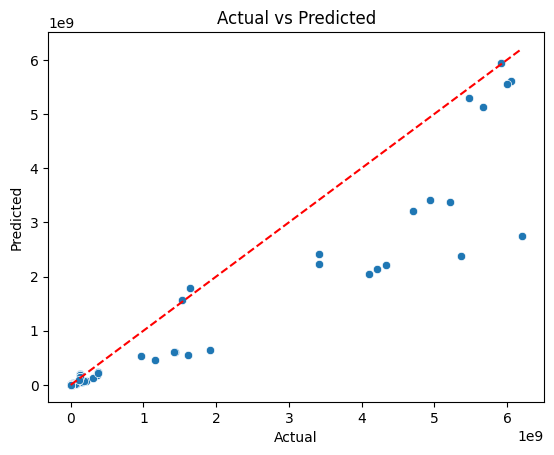

In [40]:
y_test_1d = y_test_original.values.ravel()
y_pred_1d = y_pred_original.ravel()

import seaborn as sns

sns.scatterplot(x=y_test_1d, y=y_pred_1d)
sns.lineplot(x=y_test_1d, y=y_test_1d, color='red', linestyle='--')  # y=x line
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Actual vs Predicted")
plt.show()


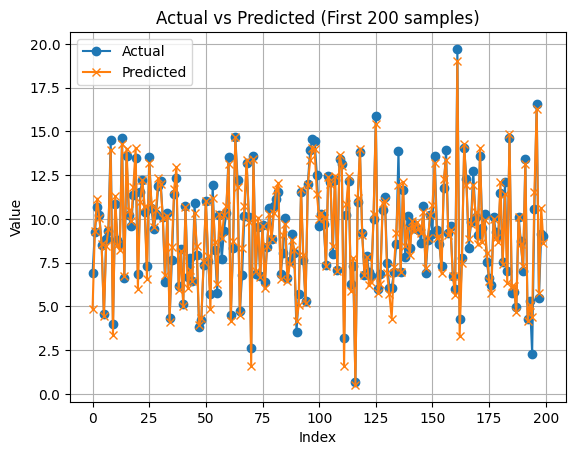

In [41]:

sample = 200  # or whatever number keeps things readable
plt.plot(pd.DataFrame(y_test[:sample]).values, label='Actual', marker='o')
plt.plot(y_pred[:sample], label='Predicted', marker='x')
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted (First 200 samples)')
plt.legend()
plt.grid(True)
plt.show()

#### Save the model 


## To Load model
loaded_model = joblib.load("model.pkl")

## To Use it
y_pred = loaded_model.predict(X_test)

In [42]:
# joblib.dump(scaler_y, "scaler_y.pkl")


In [43]:
# Save model
joblib.dump(model, "model.pkl")

['model.pkl']

In [44]:
model_columns = [c.strip() for c in X_train.columns.tolist()]
joblib.dump(model_columns, "model_columns.pkl")


['model_columns.pkl']

In [45]:
joblib.dump(scaler_X, "scaler_x.pkl")

['scaler_x.pkl']

In [46]:
# print(scaler_y.data_min_, scaler_y.data_max_)

In [47]:
data["Crop"].unique()

array(['Arecanut', 'Arhar/Tur', 'Castor seed', 'Coconut', 'Cotton(lint)',
       'Dry chillies', 'Gram', 'Jute', 'Linseed', 'Maize', 'Mesta',
       'Niger seed', 'Onion', 'Other  Rabi pulses', 'Potato',
       'Rapeseed &Mustard', 'Rice', 'Sesamum', 'Small millets',
       'Sugarcane', 'Sweet potato', 'Tapioca', 'Tobacco', 'Turmeric',
       'Wheat', 'Bajra', 'Black pepper', 'Cardamom', 'Coriander',
       'Garlic', 'Ginger', 'Groundnut', 'Horse-gram', 'Jowar', 'Ragi',
       'Cashewnut', 'Banana', 'Soyabean', 'Barley', 'Khesari', 'Masoor',
       'Moong(Green Gram)', 'Other Kharif pulses', 'Safflower',
       'Sannhamp', 'Sunflower', 'Urad', 'Peas & beans (Pulses)',
       'other oilseeds', 'Other Cereals', 'Cowpea(Lobia)',
       'Oilseeds total', 'Guar seed', 'Other Summer Pulses', 'Moth'],
      dtype=object)